## 数据

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [ ]:
#BATCH_SIZE = 20
#NUM_CLASSES = 200
#NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = 100000
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
#TRAIN_SIZE = NUM_IMAGES

#NUM_VAL_IMAGES = 9832
#VAL_IMAGES_DIR = './tiny-imagenet-200/val/'
IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
def load_training_images(image_dir, batch_size=500):

    image_index = 0
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
    names = []
    labels = []                       
    
    print("Loading training images from ", image_dir)
    # Loop through all the types directories
    for type in os.listdir(image_dir):
        if os.path.isdir(image_dir + type + '/images/'):

            type_images = os.listdir(image_dir + type + '/images/')
            # Loop through all the images of a type directory
            batch_index = 0;
            #print ("Loading Class ", type)
            for image in type_images:
                image_file = os.path.join(image_dir, type + '/images/', image)

                # reading the images as they are; no normalization, no color editing
                image_data = cv2.imread(image_file) 
                image_data = np.array(image_data)
                #print ('Loaded Image', image_file, image_data.shape)
                if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
                    images[image_index, :] = image_data.flatten()

                    labels.append(type)
                    names.append(image)
                    
                    image_index += 1
                    batch_index += 1
                if (batch_index >= batch_size):
                    break;
    
    print("Loaded Training Images", image_index)
    return (images, np.asarray(labels), np.asarray(names))

import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2
data = load_training_images(TRAINING_IMAGES_DIR, batch_size=500)
seed = np.random.randint(0,100000,10000)
data = data[0][seed]
TIM = data
data = 1
TIM = np.reshape(TIM,[10000,64,64,3])/255
TIM1=[]
for i in range(len(TIM)):
    im = cv2.resize(TIM[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
    TIM1.append(im)
TIM1 = np.array(TIM1)
np.save("TIM",TIM1)
TIM1 = 1
TIM = np.load("./TIM.npy")  

## 分开

In [ ]:

import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.image as mpimg
from tensorflow.contrib.distributions import Bernoulli
import os
import cv2
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train*1./255
x_test = x_test*1./255
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
targets = y_test.reshape(-1)
y_test = np.eye(nb_classes)[targets]

TIM = np.load("./TIM.npy")
#np.save("TIM1",TIM)
#TIMp = np.load("./TIM1.npy") 

def crop(x):
  for q in range(len(x)):
    img = x[q]
    l = []
    for i in range(8):
      for j in range(8):
        im = img[i*4:(i+1)*4,j*4:(j+1)*4,:]
        l.append(im)
        
    l1 = np.random.permutation(l)
    
    t=0
    for i in range(8):
      for j in range(8):
        img[i*4:(i+1)*4,j*4:(j+1)*4,:] = l1[t]
        t+=1
    x[q] = img
  return x

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img
def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im,axis=(1,2,3)).reshape(im.shape[0],1,1,1)
    std = np.std(im,axis=(1,2,3)).reshape(im.shape[0],1,1,1)
    std1 = std+1e-20
    im = (im-mean)/std1
    return im  
  
def stand0(im):
  im = im.astype(np.float64,copy=False)
  mean = np.mean(im)
  std = np.std(im)
  std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
  im = (im-mean)/std1
  return im

def stand(images):
  for i in range(len(images)):
    images[i] = stand0(images[i])
  return images 

def stand10(safe_images):
    safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
    return safe_images
  
def stand1(images):
  for i in range(len(images)):
    images[i] = stand10(images[i])
  return images 

def random_flip(im):
    s = np.random.randint(0,2,1)[0]
    if s == 1:
        im = im[:,:,::-1,...]
    return im

def preprocess(x_batch):
    #x_batch = stand(x_batch)
    x_batch = stand(x_batch)
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = random_flip(x_batch)
    return x_batch

  
def network(img):
        # network
  #with tf.variable_scope('V1', reuse=tf.AUTO_REUSE):
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=b)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=b)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=b)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=b)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=b)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=b)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=b)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=b)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=b)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10
def network1(img):
        # network
  #with tf.variable_scope('V1', reuse=tf.AUTO_REUSE):
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=False)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=False)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=False)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=False)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=False)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=False)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=False)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=False)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=False)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=False)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=False)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=False)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=False)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10


M = 128
n_intergal_sample = 600
D=7*7*64
h1=512
D2=10
max_auc = 0

#for d in ['/device:GPU:0','/device:GPU:1','/device:GPU:2', '/device:GPU:3']:
for d in ['/device:GPU:0']:
    with tf.device(d):
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        tf.reset_default_graph()
        # variables
        noise = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        Y = tf.placeholder(tf.float32, [None,10])
        b = tf.placeholder(tf.bool,shape=(),name='b')
        learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

        w_conv1 = tf.get_variable('w_conv1', [3,3,3,64], initializer = tf.contrib.layers.xavier_initializer())
        w_conv2 = tf.get_variable('w_conv2', [3,3,64,64], initializer = tf.contrib.layers.xavier_initializer())

        w_conv3 = tf.get_variable('w_conv3', [3,3,64,128], initializer = tf.contrib.layers.xavier_initializer())
        w_conv4 = tf.get_variable('w_conv4', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())

        w_conv5 = tf.get_variable('w_conv5', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv6 = tf.get_variable('w_conv6', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv7 = tf.get_variable('w_conv7', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())

        w_conv8 = tf.get_variable('w_conv8', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv9 = tf.get_variable('w_conv9', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv10 = tf.get_variable('w_conv10', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w_conv11 = tf.get_variable('w_conv11', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv12 = tf.get_variable('w_conv12', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv13 = tf.get_variable('w_conv13', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w0_m = tf.get_variable('w_fc1', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_m = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_m = tf.get_variable('w_fc2', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_m = tf.get_variable('b_fc2', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_m = tf.get_variable('w_fc3', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_m = tf.get_variable('b_fc3', [1,10], initializer = tf.contrib.layers.xavier_initializer())

        w0_r = tf.get_variable('w_fc1_r', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_r = tf.get_variable('b_fc1_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_r = tf.get_variable('w_fc2_r', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_r = tf.get_variable('b_fc2_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_r = tf.get_variable('w_fc3_r', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_r = tf.get_variable('b_fc3_r', [1,10], initializer = tf.contrib.layers.xavier_initializer())

        w0_sigma = w0_r**2
        b0_sigma = b0_r**2
        w1_sigma = w1_r**2
        b1_sigma = b1_r**2
        w2_sigma = w2_r**2
        b2_sigma = b2_r**2

        eps1 = tf.random_normal(shape=[n_intergal_sample,1*1*512, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps2 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps3 = tf.random_normal(shape=[n_intergal_sample,1024, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps4 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps5 = tf.random_normal(shape=[n_intergal_sample,1024, 10], mean=0.0, stddev=1,dtype=tf.float32)
        eps6 = tf.random_normal(shape=[n_intergal_sample,1,10], mean=0.0, stddev=1,dtype=tf.float32)
        
        w0 = w0_m + eps1 * w0_sigma
        b0 = b0_m + eps2 * b0_sigma
        w1 = w1_m + eps3 * w1_sigma
        b1 = b1_m + eps4 * b1_sigma
        w2 = w2_m + eps5 * w2_sigma
        b2 = b2_m + eps6 * b2_sigma

        # network


        #evaluation
        logits0 = network(X)
        logits = tf.reduce_mean(logits0,0)
        output0 = tf.nn.softmax(logits0)
        cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y)

        probs = tf.reduce_sum(output0*Y,2)
        prob=tf.reduce_mean(probs,0)#积分
        log_prob = tf.log(prob+1e-30)#取log
        #p = tf.reduce_mean(log_prob)#求和
        p = tf.reduce_mean(-cross_ent)

        output, var0 = tf.nn.moments(output0,0)#batch*10
        prob1 = tf.reduce_sum(output*Y,1)
        max_p = tf.reduce_max(output,1)#batch*1
        ent = tf.reduce_sum(-tf.log(output+1e-30)*output,1)#batch*1
        Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-30)*output0,2),0)#batch*1
        MI = ent - Eent#batch*1
        MI_mean = tf.reduce_sum(MI)

        correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        #noise = tf.reshape(tf.random_normal(shape=[1,32*32*3*M], mean=0.0, stddev=1, dtype=tf.float32),[M,32,32,3])

        #noise = tf.image.per_image_standardization(noise)

        logits1 = network(noise)
        output1 = tf.nn.softmax(logits1)
        output_noise, varent_noise = tf.nn.moments(output1,0)
        max_p_noise = tf.reduce_max(output_noise,1)
        ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-30)*output_noise,1)
        Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-30)*output1,2),0)
        MI_noise = ent_noise - Eent_noise
        MI_noise_mean = tf.reduce_sum(MI_noise)

        correct_pred_noise = tf.equal(tf.argmax(output_noise,1), tf.argmax(Y,1))
        accuracy_noise = tf.reduce_mean(tf.cast(correct_pred_noise, tf.float32))

        regularization = 1e-6*(tf.reduce_sum(tf.square(w0_m))+tf.reduce_sum(tf.square(b0_m))
                               +tf.reduce_sum(tf.square(w1_m))+tf.reduce_sum(tf.square(b1_m))
                               +tf.reduce_sum(tf.square(w2_m))+tf.reduce_sum(tf.square(b2_m)))
                               #+tf.reduce_sum(tf.square(w_conv1))+tf.reduce_sum(tf.square(w_conv2))
                               #+tf.reduce_sum(tf.square(w_conv3))+tf.reduce_sum(tf.square(w_conv4))
                               #+tf.reduce_sum(tf.square(w_conv5))+tf.reduce_sum(tf.square(w_conv6))+tf.reduce_sum(tf.square(w_conv7))
                               #+tf.reduce_sum(tf.square(w_conv8))+tf.reduce_sum(tf.square(w_conv9))+tf.reduce_sum(tf.square(w_conv10))
                               #+tf.reduce_sum(tf.square(w_conv11))+tf.reduce_sum(tf.square(w_conv12))+tf.reduce_sum(tf.square(w_conv13)))
        p = p*1
        loss = -p + regularization*1 - MI_noise_mean*.7
# training

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
saver = tf.train.Saver(max_to_keep=10)

config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=13
    save_path = saver.restore(sess, "./density_estimation_cifar10/classification_mnist13/model.ckpt" )
    for i in range(100001):
        #pp = sess.run(pop_mean1,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
        #print(0.04)
        start_time1 = time.time()
        seed = np.random.randint(0,50000,M)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        
        #pp = sess.run(MI_noise_mean,{X: my_noise, Y: y_batch,noise:my_noise, b:False})
        #pp1 = sess.run(MI_mean,{X: my_noise, Y: y_batch,noise:my_noise, b:False})
        #print(pp,pp1)
        
        #my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
        #my_noise = np.reshape(np.random.uniform(0,1,[32*32*3*M]),[M,32,32,3])
        #my_noise = TIMp[np.random.randint(0,10000,M)]
        if i%3 == 0:
          #my_noise = np.copy(x_train[np.random.randint(0,50000,M)])
          #my_noise = crop(my_noise)
          #my_noise = stand(my_noise)
          my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
          
        if i%3 == 1:
          my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
          #my_noise = stand(my_noise)
            
        if i%3 == 2:
          my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
          #my_noise = stand(my_noise)
            
        if i%1000==0:
            loss_now = sess.run(loss,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            loss_now1 = sess.run(MI_noise_mean*.7,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            print("loss",loss_now,"-p+regular ",loss_now+loss_now1,"MI",loss_now1)
            
            train_accuracy=[]
            seed1 = np.random.randint(0,50000,10000)
            x_vali = x_train[seed1]
            y_vali = y_train[seed1]
            for j in range(0,100):
                imgs_in = x_vali[j*100:(j+1)*100]
                labels_in = y_vali[j*100:(j+1)*100]
                imgs_in=stand(imgs_in)
                acc0 = sess.run(accuracy,{X:imgs_in,Y:labels_in,noise:imgs_in,b:False})
                train_accuracy.append(acc0)
            train_accuracy = np.array(train_accuracy)
            train_accuracy = np.mean(train_accuracy)
            
            test_accuracy=[]
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in=stand(imgs_in)
                #imgs_in=stand1(imgs_in)
                acc = sess.run(accuracy,{X:imgs_in,Y:labels_in,noise:imgs_in,b:False})
                maxp_in1 = sess.run(max_p,{X:imgs_in,noise:imgs_in,b:False})
                ent_in1 = sess.run(ent,{X:imgs_in,noise:imgs_in,b:False})
                MI_in1 = sess.run(MI,{X:imgs_in,noise:imgs_in,b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy,"train accuracy",train_accuracy)

            for t in range(0,2):
                '''
                if t == 0:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                '''
                if t == 0:
                    safe_images = np.copy(TIM)
                    print("TIM:")
                if t == 1:
                    safe_images = np.reshape(np.random.normal(0,1,[32*32*3*10000]),[10000,32,32,3])
                    #safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
                    print("noise:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,100):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    imgs_OOD = stand(imgs_OOD)
                    #imgs_OOD = stand1(imgs_OOD)
                    maxp_OOD1 = sess.run(max_p,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    ent_OOD1 = sess.run(ent,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    MI_OOD1 = sess.run(MI,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
                if t == 0:
                    tmp_indicator = round(100*roc_auc_score(labels, examples), 2)

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
            if i==-1 and i!=0:
              print("原始") 
              train_accuracy=[]
              seed1 = np.random.randint(0,50000,10000)
              x_vali = x_train[seed1]
              y_vali = y_train[seed1]
              for j in range(0,1000):
                  imgs_in = x_vali[j*10:(j+1)*10]
                  labels_in = y_vali[j*10:(j+1)*10]
                  imgs_in=stand(imgs_in)
                  acc0 = sess.run(accuracy,{X:imgs_in,Y:labels_in,noise:imgs_in,b:True})
                  train_accuracy.append(acc0)
              train_accuracy = np.array(train_accuracy)
              train_accuracy = np.mean(train_accuracy)

              test_accuracy=[]
              maxp_in = []
              ent_in = []
              MI_in = []
              for j in range(0,1000):
                  imgs_in = x_test[j*10:(j+1)*10]
                  labels_in = y_test[j*10:(j+1)*10]
                  imgs_in=stand(imgs_in)
                  #imgs_in=stand1(imgs_in)
                  acc = sess.run(accuracy,{X:imgs_in,Y:labels_in,noise:imgs_in,b:True})
                  maxp_in1 = sess.run(max_p,{X:imgs_in,noise:imgs_in,b:True})
                  ent_in1 = sess.run(ent,{X:imgs_in,noise:imgs_in,b:True})
                  MI_in1 = sess.run(MI,{X:imgs_in,noise:imgs_in,b:True})
                  test_accuracy.append(acc)
                  maxp_in.extend(maxp_in1)
                  ent_in.extend(ent_in1)
                  MI_in.extend(MI_in1)
              test_accuracy = np.array(test_accuracy)
              test_accuracy = np.mean(test_accuracy)
              maxp_in = np.array(maxp_in)
              ent_in = np.array(ent_in)
              MI_in = np.array(MI_in)
              print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy,"train accuracy",train_accuracy)

              for t in range(0,2):
                  '''
                  if t == 0:
                      safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                      print("gauss noise:")

                  if t == 1:
                      safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                      print("average noise:")
                  '''
                  if t == 0:
                      safe_images = TIM
                      print("TIM:")
                  if t == 1:
                      safe_images = np.reshape(np.random.uniform(0,1,[32*32*3*10000]),[10000,32,32,3])
                      #safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
                      print("noise:")
                  maxp_OOD = []
                  ent_OOD = []
                  MI_OOD = []

                  for k in range(0,1000):
                      imgs_OOD = safe_images[k*10:(k+1)*10]
                      imgs_OOD = stand(imgs_OOD)
                      #imgs_OOD = stand1(imgs_OOD)
                      maxp_OOD1 = sess.run(max_p,{X:imgs_OOD,noise:imgs_OOD,b:True})
                      ent_OOD1 = sess.run(ent,{X:imgs_OOD,noise:imgs_OOD,b:True})
                      MI_OOD1 = sess.run(MI,{X:imgs_OOD,noise:imgs_OOD,b:True})
                      maxp_OOD.extend(maxp_OOD1)
                      ent_OOD.extend(ent_OOD1)
                      MI_OOD.extend(MI_OOD1)
                  maxp_OOD = np.array(maxp_OOD)
                  ent_OOD = np.array(ent_OOD)
                  MI_OOD = np.array(MI_OOD)
                  '''
                  print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                  print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                  print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                  print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                  print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                  '''
                  print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                  print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                  print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                  print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))


                  safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[10000,1])
                  labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                  labels[safe.shape[0]:] += 1
                  examples = np.squeeze(np.vstack((safe, risky)))
                  print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                  print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                  safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[10000,1])
                  labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                  labels[safe.shape[0]:] += 1
                  examples = np.squeeze(np.vstack((safe, risky)))
                  print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                  print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
                  if t == 0:
                      tmp_indicator = round(100*roc_auc_score(labels, examples), 2)

                  safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[10000,1])
                  labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                  labels[safe.shape[0]:] += 1
                  examples = np.squeeze(np.vstack((safe, risky)))
                  print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                  print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                  print("----------------------------------------")  
            print("############################################")
        '''   
        #慢    
        if i < 10000:
            a = 0.0001
        elif i < 20000:
            a = 0.00001
        elif i < 40000:
            a = 0.000001
        elif i < 60000:
            a = 0.0000001
        elif i < 80000:
            a = 0.00000001
        else:
            a = 0.000000001
            
        if i < 10000:
            a = 0.0001
        elif i < 20000:
            a = 0.00001
        elif i < 40000:
            a = 0.000001
        elif i < 60000:
            a = 0.0000001
        elif i < 80000:
            a = 0.00000001
        else:
            a = 0.000000001
            
        
            
        #try中
        if i < 10000:
            a = 0.00005
        elif i < 20000:
            a = 0.00001
        elif i < 30000:
            a = 0.000003
        elif i < 40000:
            a = 0.000001
        elif i < 50000:
            a = 0.0000003
        elif i < 60000:
            a = 0.0000001
        elif i < 70000:
            a = 0.00000003
        else:
            a = 0.00000001
            
        #中  
        if i < 5000:
            a = 0.001
        elif i < 10000:
            a = 0.0003
        elif i < 20000:
            a = 0.0001
        elif i < 30000:
            a = 0.00003
        elif i < 40000:
            a = 0.00001
        elif i < 50000:
            a = 0.000003
        elif i < 60000:
            a = 0.000001
        elif i < 70000:
            a = 0.0000003
        else:
            a = 0.0000001
            
        #smooth    
        if i < 10000:
            a = 0.0003
        elif i < 20000:
            a = 0.0001
        elif i < 30000:
            a = 0.00003
        elif i < 40000:
            a = 0.00001
        elif i < 50000:
            a = 0.000003
        elif i < 60000:
            a = 0.000001
        elif i < 70000:
            a = 0.0000003
        else:
            a = 0.0000001
        '''    
        #快  
        i+=13000
        if i < 10000:
            a = 0.001
        elif i < 20000:
            a = 0.0003
        elif i < 30000:
            a = 0.0001
        elif i < 40000:
            a = 0.00003
        elif i < 50000:
            a = 0.00001
        elif i < 60000:
            a = 0.000003
        elif i < 70000:
            a = 0.000001
        elif i < 80000:
            a = 0.0000003
        else:
            a = 0.0000001

        sess.run(train_step,{X: x_batch, Y: y_batch,noise:my_noise, b:True, learning_rate:a*.2})
        if i%1000==0:
            save_path = saver.save(sess, "./density_estimation_cifar10/classification_mnist%s/model.ckpt" % model_id)
            print("model",model_id,"saved.7")
            model_id+=1 


# 共享

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.image as mpimg
from tensorflow.contrib.distributions import Bernoulli
import os
import cv2

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train*1./255
x_test = x_test*1./255
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
targets = y_test.reshape(-1)
y_test = np.eye(nb_classes)[targets]

TIM = np.load("./TIM.npy")  

def crop(x):
  for q in range(len(x)):
    img = x[q]
    l = []
    for i in range(8):
      for j in range(8):
        im = img[i*4:(i+1)*4,j*4:(j+1)*4,:]
        l.append(im)
     
    l1 = np.random.permutation(l)
    
    t=0
    for i in range(8):
      for j in range(8):
        img[i*4:(i+1)*4,j*4:(j+1)*4,:] = l1[t]
        t+=1
    x[q] = img
  return x
def crop1(x):
  for q in range(len(x)):
    img = x[q]
    l = []
    for i in range(4):
      for j in range(4):
        im = img[i*8:(i+1)*8,j*8:(j+1)*8,:]
        l.append(im)
     
    l1 = np.random.permutation(l)
    
    t=0
    for i in range(4):
      for j in range(4):
        img[i*8:(i+1)*8,j*8:(j+1)*8,:] = l1[t]
        t+=1
    x[q] = img
  return x

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img
def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im,axis=(1,2,3)).reshape(im.shape[0],1,1,1)
    std = np.std(im,axis=(1,2,3)).reshape(im.shape[0],1,1,1)
    std1 = std+1e-20
    im = (im-mean)/std1
    return im  
  
def stand0(im):
  im = im.astype(np.float64,copy=False)
  mean = np.mean(im)
  std = np.std(im)
  std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
  im = (im-mean)/std1
  return im

def stand(images):
  for i in range(len(images)):
    images[i] = stand0(images[i])
  return images 

def stand10(safe_images):
    safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
    return safe_images
  
def stand1(images):
  for i in range(len(images)):
    images[i] = stand10(images[i])
  return images 

def random_flip(im):
    s = np.random.randint(0,2,1)[0]
    if s == 1:
        im = im[:,:,::-1,...]
    return im

def preprocess(x_batch):
    #x_batch = stand(x_batch)
    x_batch = stand(x_batch)
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = random_flip(x_batch)
    return x_batch

'''
epsilon = 1e-2
def batch_norm(inputs, scale, beta, training, decay = 0.999):
    
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
    train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
    train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))

    with tf.control_dependencies([train_mean, train_var]):
      return (1.-training)*tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)+(training)*tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    
    
    if training:
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
    else:
        #with tf.control_dependencies([train_mean, train_var]):
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
'''

epsilon = 1e-3
          
def batch_norm(inputs, scale, beta, training, decay = 0.99):
    batch_mean, batch_var = tf.nn.moments(inputs, [0,1,2])
    ema = tf.train.ExponentialMovingAverage(decay=0.99)
    
    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
          
    def otherwise():
        #ema_apply_op = ema.apply([batch_mean, batch_var])
        #with tf.control_dependencies([ema_apply_op]):
        return tf.identity(ema.average(batch_mean)), tf.identity(ema.average(batch_var))
    
    mean, var = tf.cond(training,mean_var_with_update,otherwise)
    normed = tf.nn.batch_normalization(inputs, mean, var, beta, scale, 1e-3)
    return normed
  
def batch_norm(inputs, scale, beta, pop_mean, pop_var,training, decay = 0.99):
    #pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    #pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
    train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
    train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))
    
    def mean_var_with_update():
      with tf.control_dependencies([train_mean, train_var]):
        return tf.identity(batch_mean), tf.identity(batch_var)
      
    def otherwise():
      return tf.identity(pop_mean), tf.identity(pop_var)

    mean, var = tf.cond(training, mean_var_with_update, otherwise)
    normed = tf.nn.batch_normalization(inputs, mean, var, beta, scale, 1e-3)
    return normed
  
epsilon = 1e-3
def batch_norm(inputs, scale, beta, pop_mean, pop_var,training, decay = 0.99):
    #pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    #pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
    train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
    train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))
    if training:
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        #with tf.control_dependencies([train_mean, train_var]):
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

def network(img, dd):
    with tf.variable_scope('V1', reuse=tf.AUTO_REUSE):
    #haha = tf.assign(c,cc)
    #with tf.control_dependencies([haha]):
        # network
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        #h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=dd)
        h_conv1 = batch_norm(tf.nn.relu(con1), scale1, beta1, pop_mean1, pop_var1,training=dd)
        #h_conv1 = tf.nn.relu(batch_norm(con1, scale1, beta1, training=dd))
        #h_conv1 = tf.nn.relu(con1+b_1)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        #h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=dd)
        h_conv2 = batch_norm(tf.nn.relu(con2), scale2, beta2, pop_mean2, pop_var2,training=dd)
        #h_conv2 = tf.nn.relu(batch_norm(con2, scale2, beta2, training=dd))
        #h_conv2 = tf.nn.relu(con2+b_2)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        #h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=dd)
        h_conv3 = batch_norm(tf.nn.relu(con3), scale3, beta3, pop_mean3, pop_var3,training=dd)
        #h_conv3 = tf.nn.relu(batch_norm(con3, scale3, beta3, training=dd))
        #h_conv3 = tf.nn.relu(con3+b_3)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        #h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=dd)
        h_conv4 = batch_norm(tf.nn.relu(con4), scale4, beta4, pop_mean4, pop_var4,training=dd)
        #h_conv4 = tf.nn.relu(batch_norm(con4, scale4, beta4, training=dd))
        #h_conv4 = tf.nn.relu(con4+b_4)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=dd)
        h_conv5 = batch_norm(tf.nn.relu(con5), scale5, beta5, pop_mean5, pop_var5,training=dd)
        #h_conv5 = tf.nn.relu(batch_norm(con5, scale5, beta5, training=dd))
        #h_conv5 = tf.nn.relu(con5+b_5)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=dd)
        h_conv6 = batch_norm(tf.nn.relu(con6), scale6, beta6, pop_mean6, pop_var6,training=dd)
        #h_conv6 = tf.nn.relu(batch_norm(con6, scale6, beta6, training=dd))
        #h_conv6 = tf.nn.relu(con6+b_6)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        #h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=dd)
        h_conv7 = batch_norm(tf.nn.relu(con7), scale7, beta7, pop_mean7, pop_var7,training=dd)
        #h_conv7 = tf.nn.relu(batch_norm(con7, scale7, beta7, training=dd))
        #h_conv7 = tf.nn.relu(con7+b_7)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        #h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=dd)
        h_conv8 = batch_norm(tf.nn.relu(con8), scale8, beta8, pop_mean8, pop_var8,training=dd)
        #h_conv8 = tf.nn.relu(batch_norm(con8, scale8, beta8, training=dd))
        #h_conv8 = tf.nn.relu(con8+b_8)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        #h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=dd)
        h_conv9 = batch_norm(tf.nn.relu(con9), scale9, beta9, pop_mean9, pop_var9,training=dd)
        #h_conv9 = tf.nn.relu(batch_norm(con9, scale9, beta9, training=dd))
        #h_conv9 = tf.nn.relu(con9+b_9)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        #h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=dd)
        h_conv10 = batch_norm(tf.nn.relu(con10), scale10, beta10, pop_mean10, pop_var10,training=dd)
        #h_conv10 = tf.nn.relu(batch_norm(con10, scale10, beta10, training=dd))
        #h_conv10 = tf.nn.relu(con10+b_10)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        #h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=dd)
        h_conv11 = batch_norm(tf.nn.relu(con11), scale11, beta11, pop_mean11, pop_var11,training=dd)
        #h_conv11 = tf.nn.relu(batch_norm(con11, scale11, beta11, training=dd))
        #h_conv11 = tf.nn.relu(con11+b_11)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        #h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=dd)
        h_conv12 = batch_norm(tf.nn.relu(con12), scale12, beta12, pop_mean12, pop_var12,training=dd)
        #h_conv12 = tf.nn.relu(batch_norm(con12, scale12, beta12, training=dd))
        #h_conv12 = tf.nn.relu(con12+b_12)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        #h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=dd)
        h_conv13 = batch_norm(tf.nn.relu(con13), scale13, beta13, pop_mean13, pop_var13,training=dd)
        #h_conv13 = tf.nn.relu(batch_norm(con13, scale13, beta13, training=dd))
        #h_conv13 = tf.nn.relu(con13+b_13)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10
      
def network1(img, dd):
    with tf.variable_scope('V1', reuse=tf.AUTO_REUSE):
    #haha = tf.assign(c,cc)
    #with tf.control_dependencies([haha]):
        # network
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        #h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=dd)
        h_conv1 = batch_norm(tf.nn.relu(con1), sc1, bt1, pop_mean1, pop_var1,training=dd)
        #h_conv1 = tf.nn.relu(batch_norm(con1, scale1, beta1, training=dd))
        #h_conv1 = tf.nn.relu(con1+b_1)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        #h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=dd)
        h_conv2 = batch_norm(tf.nn.relu(con2), sc2, bt2, pop_mean2, pop_var2,training=dd)
        #h_conv2 = tf.nn.relu(batch_norm(con2, scale2, beta2, training=dd))
        #h_conv2 = tf.nn.relu(con2+b_2)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        #h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=dd)
        h_conv3 = batch_norm(tf.nn.relu(con3), sc3, bt3, pop_mean3, pop_var3,training=dd)
        #h_conv3 = tf.nn.relu(batch_norm(con3, scale3, beta3, training=dd))
        #h_conv3 = tf.nn.relu(con3+b_3)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        #h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=dd)
        h_conv4 = batch_norm(tf.nn.relu(con4), sc4, bt4, pop_mean4, pop_var4,training=dd)
        #h_conv4 = tf.nn.relu(batch_norm(con4, scale4, beta4, training=dd))
        #h_conv4 = tf.nn.relu(con4+b_4)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=dd)
        h_conv5 = batch_norm(tf.nn.relu(con5), sc5, bt5, pop_mean5, pop_var5,training=dd)
        #h_conv5 = tf.nn.relu(batch_norm(con5, scale5, beta5, training=dd))
        #h_conv5 = tf.nn.relu(con5+b_5)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=dd)
        h_conv6 = batch_norm(tf.nn.relu(con6), sc6, bt6, pop_mean6, pop_var6,training=dd)
        #h_conv6 = tf.nn.relu(batch_norm(con6, scale6, beta6, training=dd))
        #h_conv6 = tf.nn.relu(con6+b_6)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        #h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=dd)
        h_conv7 = batch_norm(tf.nn.relu(con7), sc7, bt7, pop_mean7, pop_var7,training=dd)
        #h_conv7 = tf.nn.relu(batch_norm(con7, scale7, beta7, training=dd))
        #h_conv7 = tf.nn.relu(con7+b_7)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        #h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=dd)
        h_conv8 = batch_norm(tf.nn.relu(con8), sc8, bt8, pop_mean8, pop_var8,training=dd)
        #h_conv8 = tf.nn.relu(batch_norm(con8, scale8, beta8, training=dd))
        #h_conv8 = tf.nn.relu(con8+b_8)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        #h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=dd)
        h_conv9 = batch_norm(tf.nn.relu(con9), sc9, bt9, pop_mean9, pop_var9,training=dd)
        #h_conv9 = tf.nn.relu(batch_norm(con9, scale9, beta9, training=dd))
        #h_conv9 = tf.nn.relu(con9+b_9)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        #h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=dd)
        h_conv10 = batch_norm(tf.nn.relu(con10), sc10, bt10, pop_mean10, pop_var10,training=dd)
        #h_conv10 = tf.nn.relu(batch_norm(con10, scale10, beta10, training=dd))
        #h_conv10 = tf.nn.relu(con10+b_10)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        #h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=dd)
        h_conv11 = batch_norm(tf.nn.relu(con11), sc11, bt11, pop_mean11, pop_var11,training=dd)
        #h_conv11 = tf.nn.relu(batch_norm(con11, scale11, beta11, training=dd))
        #h_conv11 = tf.nn.relu(con11+b_11)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        #h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=dd)
        h_conv12 = batch_norm(tf.nn.relu(con12), sc12, bt12, pop_mean12, pop_var12,training=dd)
        #h_conv12 = tf.nn.relu(batch_norm(con12, scale12, beta12, training=dd))
        #h_conv12 = tf.nn.relu(con12+b_12)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        #h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=dd)
        h_conv13 = batch_norm(tf.nn.relu(con13), sc13, bt13, pop_mean13, pop_var13,training=dd)
        #h_conv13 = tf.nn.relu(batch_norm(con13, scale13, beta13, training=dd))
        #h_conv13 = tf.nn.relu(con13+b_13)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10

M = 128
n_intergal_sample = 30
D=7*7*64
h1=512
D2=10
max_auc = 0

#for d in ['/device:GPU:0','/device:GPU:1','/device:GPU:2', '/device:GPU:3']:
for d in ['/device:GPU:0']:
    with tf.device(d):
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        tf.reset_default_graph()
        # variables
        noise = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        Y = tf.placeholder(tf.float32, [None,10])
        b = tf.placeholder(tf.bool,shape=(),name='b')
        #c = tf.Variable(False, trainable=False)
        learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

        pop_var1 = tf.Variable(tf.ones([64]), trainable=False)
        pop_mean1 = tf.Variable(tf.zeros([64]), trainable=False)
        pop_var2 = tf.Variable(tf.ones([64]), trainable=False)
        pop_mean2 = tf.Variable(tf.zeros([64]), trainable=False)
        pop_var3 = tf.Variable(tf.ones([128]), trainable=False)
        pop_mean3 = tf.Variable(tf.zeros([128]), trainable=False)
        pop_var4 = tf.Variable(tf.ones([128]), trainable=False)
        pop_mean4 = tf.Variable(tf.zeros([128]), trainable=False)
        pop_var5 = tf.Variable(tf.ones([256]), trainable=False)
        pop_mean5 = tf.Variable(tf.zeros([256]), trainable=False)
        pop_var6 = tf.Variable(tf.ones([256]), trainable=False)
        pop_mean6 = tf.Variable(tf.zeros([256]), trainable=False)
        pop_var7 = tf.Variable(tf.ones([256]), trainable=False)
        pop_mean7 = tf.Variable(tf.zeros([256]), trainable=False)
        pop_var8 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean8 = tf.Variable(tf.zeros([512]), trainable=False)
        pop_var9 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean9 = tf.Variable(tf.zeros([512]), trainable=False)
        pop_var10 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean10 = tf.Variable(tf.zeros([512]), trainable=False)
        pop_var11 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean11 = tf.Variable(tf.zeros([512]), trainable=False)
        pop_var12 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean12 = tf.Variable(tf.zeros([512]), trainable=False)
        pop_var13 = tf.Variable(tf.ones([512]), trainable=False)
        pop_mean13 = tf.Variable(tf.zeros([512]), trainable=False)
        
        scale1 = tf.Variable(tf.ones([64]))
        beta1 = tf.Variable(tf.zeros([64]))
        scale2 = tf.Variable(tf.ones([64]))
        beta2 = tf.Variable(tf.zeros([64]))
        scale3 = tf.Variable(tf.ones([128]))
        beta3 = tf.Variable(tf.zeros([128]))
        scale4 = tf.Variable(tf.ones([128]))
        beta4 = tf.Variable(tf.zeros([128]))
        scale5 = tf.Variable(tf.ones([256]))
        beta5 = tf.Variable(tf.zeros([256]))
        scale6 = tf.Variable(tf.ones([256]))
        beta6 = tf.Variable(tf.zeros([256]))
        scale7 = tf.Variable(tf.ones([256]))
        beta7 = tf.Variable(tf.zeros([256]))
        scale8 = tf.Variable(tf.ones([512]))
        beta8 = tf.Variable(tf.zeros([512]))
        scale9 = tf.Variable(tf.ones([512]))
        beta9 = tf.Variable(tf.zeros([512]))
        scale10 = tf.Variable(tf.ones([512]))
        beta10 = tf.Variable(tf.zeros([512]))
        scale11 = tf.Variable(tf.ones([512]))
        beta11 = tf.Variable(tf.zeros([512]))
        scale12 = tf.Variable(tf.ones([512]))
        beta12 = tf.Variable(tf.zeros([512]))
        scale13 = tf.Variable(tf.ones([512]))
        beta13 = tf.Variable(tf.zeros([512]))
        
        bt1 = tf.stop_gradient(tf.identity(beta1))
        sc1 = tf.stop_gradient(tf.identity(scale1))
        bt2 = tf.stop_gradient(tf.identity(beta2))
        sc2 = tf.stop_gradient(tf.identity(scale2))
        bt3 = tf.stop_gradient(tf.identity(beta3))
        sc3 = tf.stop_gradient(tf.identity(scale3))
        bt4 = tf.stop_gradient(tf.identity(beta4))
        sc4 = tf.stop_gradient(tf.identity(scale4))
        bt5 = tf.stop_gradient(tf.identity(beta5))
        sc5 = tf.stop_gradient(tf.identity(scale5))
        bt6 = tf.stop_gradient(tf.identity(beta6))
        sc6 = tf.stop_gradient(tf.identity(scale6))        
        bt7 = tf.stop_gradient(tf.identity(beta7))
        sc7 = tf.stop_gradient(tf.identity(scale7))        
        bt8 = tf.stop_gradient(tf.identity(beta8))
        sc8 = tf.stop_gradient(tf.identity(scale8))        
        bt9 = tf.stop_gradient(tf.identity(beta9))
        sc9 = tf.stop_gradient(tf.identity(scale9))
        bt10 = tf.stop_gradient(tf.identity(beta10))
        sc10 = tf.stop_gradient(tf.identity(scale10))        
        bt11 = tf.stop_gradient(tf.identity(beta11))
        sc11 = tf.stop_gradient(tf.identity(scale11))
        bt12 = tf.stop_gradient(tf.identity(beta12))
        sc12 = tf.stop_gradient(tf.identity(scale12))        
        bt13 = tf.stop_gradient(tf.identity(beta13))
        sc13 = tf.stop_gradient(tf.identity(scale13))
        
        w_conv1 = tf.get_variable('w_conv1', [3,3,3,64], initializer = tf.contrib.layers.xavier_initializer())
        w_conv2 = tf.get_variable('w_conv2', [3,3,64,64], initializer = tf.contrib.layers.xavier_initializer())

        w_conv3 = tf.get_variable('w_conv3', [3,3,64,128], initializer = tf.contrib.layers.xavier_initializer())
        w_conv4 = tf.get_variable('w_conv4', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())

        w_conv5 = tf.get_variable('w_conv5', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv6 = tf.get_variable('w_conv6', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv7 = tf.get_variable('w_conv7', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())

        w_conv8 = tf.get_variable('w_conv8', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv9 = tf.get_variable('w_conv9', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv10 = tf.get_variable('w_conv10', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w_conv11 = tf.get_variable('w_conv11', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv12 = tf.get_variable('w_conv12', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv13 = tf.get_variable('w_conv13', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w0_m = tf.get_variable('w_fc1', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_m = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_m = tf.get_variable('w_fc2', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_m = tf.get_variable('b_fc2', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_m = tf.get_variable('w_fc3', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_m = tf.get_variable('b_fc3', [1,10], initializer = tf.contrib.layers.xavier_initializer())
        
        w0_r = tf.get_variable('w_fc1_r', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_r = tf.get_variable('b_fc1_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_r = tf.get_variable('w_fc2_r', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_r = tf.get_variable('b_fc2_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_r = tf.get_variable('w_fc3_r', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_r = tf.get_variable('b_fc3_r', [1,10], initializer = tf.contrib.layers.xavier_initializer())

        w0_sigma = w0_r**2
        b0_sigma = b0_r**2
        w1_sigma = w1_r**2
        b1_sigma = b1_r**2
        w2_sigma = w2_r**2
        b2_sigma = b2_r**2

        eps1 = tf.random_normal(shape=[n_intergal_sample,1*1*512, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps2 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps3 = tf.random_normal(shape=[n_intergal_sample,1024, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps4 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps5 = tf.random_normal(shape=[n_intergal_sample,1024, 10], mean=0.0, stddev=1,dtype=tf.float32)
        eps6 = tf.random_normal(shape=[n_intergal_sample,1,10], mean=0.0, stddev=1,dtype=tf.float32)

        w0 = w0_m + eps1 * w0_sigma
        b0 = b0_m + eps2 * b0_sigma
        w1 = w1_m + eps3 * w1_sigma
        b1 = b1_m + eps4 * b1_sigma
        w2 = w2_m + eps5 * w2_sigma
        b2 = b2_m + eps6 * b2_sigma

        # network


        #evaluation
        ###训练接口
        logits0 = network(X,True)
        logits = tf.reduce_mean(logits0,0)
        output0 = tf.nn.softmax(logits0)
        cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y)
        
        probs = tf.reduce_sum(output0*Y,2)
        prob=tf.reduce_mean(probs,0)#积分
        log_prob = tf.log(prob+1e-30)#取log
        #p = tf.reduce_mean(log_prob)#求和
        p = tf.reduce_mean(-cross_ent)

        output, var0 = tf.nn.moments(output0,0)#batch*10
        prob1 = tf.reduce_sum(output*Y,1)
        max_p = tf.reduce_max(output,1)
        ent = tf.reduce_sum(-tf.log(output+1e-30)*output,1)
        Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-30)*output0,2),0)
        MI = ent - Eent
        MI_mean = tf.reduce_sum(MI)

        correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
        ###测试接口
        logits2 = network(X,False)
        logits22 = tf.reduce_mean(logits2,0)
        cross_ent_test = tf.nn.softmax_cross_entropy_with_logits(logits = logits22, labels=Y)
        p_test = tf.reduce_mean(-cross_ent_test)
        
        output2 = tf.nn.softmax(logits2)
        output_test, var_test = tf.nn.moments(output2,0)#batch*10
        max_p_test = tf.reduce_max(output_test,1)
        ent_test = tf.reduce_sum(-tf.log(output_test+1e-30)*output_test,1)
        Eent_test = tf.reduce_mean(tf.reduce_sum(-tf.log(output2+1e-30)*output2,2),0)
        MI_test = ent_test - Eent_test
        MI_mean_test = tf.reduce_sum(MI_test)

        correct_pred_test = tf.equal(tf.argmax(output_test,1), tf.argmax(Y,1))
        accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))

        ##noise接口
        logits1 = network1(noise,False)
        output1 = tf.nn.softmax(logits1)
        output_noise, varent_noise = tf.nn.moments(output1,0)
        max_p_noise = tf.reduce_max(output_noise,1)
        ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-30)*output_noise,1)
        Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-30)*output1,2),0)
        MI_noise = ent_noise - Eent_noise
        MI_noise_mean = tf.reduce_sum(MI_noise)
        
        correct_pred_noise = tf.equal(tf.argmax(output_noise,1), tf.argmax(Y,1))
        accuracy_noise = tf.reduce_mean(tf.cast(correct_pred_noise, tf.float32))

        regularization = 1e-4*(tf.reduce_sum(tf.square(w0_m))+tf.reduce_sum(tf.square(b0_m))
                               +tf.reduce_sum(tf.square(w1_m))+tf.reduce_sum(tf.square(b1_m))
                               +tf.reduce_sum(tf.square(w2_m))+tf.reduce_sum(tf.square(b2_m))
                               +tf.reduce_sum(tf.square(w_conv1))+tf.reduce_sum(tf.square(w_conv2))
                               +tf.reduce_sum(tf.square(w_conv3))+tf.reduce_sum(tf.square(w_conv4))
                               +tf.reduce_sum(tf.square(w_conv5))+tf.reduce_sum(tf.square(w_conv6))+tf.reduce_sum(tf.square(w_conv7))
                               +tf.reduce_sum(tf.square(w_conv8))+tf.reduce_sum(tf.square(w_conv9))+tf.reduce_sum(tf.square(w_conv10))
                               +tf.reduce_sum(tf.square(w_conv11))+tf.reduce_sum(tf.square(w_conv12))+tf.reduce_sum(tf.square(w_conv13)))
        
        regu = 0.*(tf.reduce_sum(tf.square(w0_r))+tf.reduce_sum(tf.square(b0_r))
                   +tf.reduce_sum(tf.square(w1_r))+tf.reduce_sum(tf.square(b1_r))
                   +tf.reduce_sum(tf.square(w2_r))+tf.reduce_sum(tf.square(b2_r)))

        loss = -p*0 + regularization - MI_noise_mean*0.4 - regu
        loss_test = -p_test + regularization - MI_noise_mean*0.4 - regu
# training

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

saver = tf.train.Saver(max_to_keep=5)

config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./density_estimation_cifar10/classification_mnist17/model.ckpt" )
    for i in range(180000):
        start_time1 = time.time()
        seed = np.random.randint(0,50000,M)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        '''
        for ind in range(len(TIM)):
          mp = sess.run(max_p_test,{X:TIM[ind].reshape([1,32,32,3])})
          lb = sess.run(output_test,{X:TIM[ind].reshape([1,32,32,3])})
          #print(ind,mp,TIM[ind].mean(),TIM[ind].std())
          if mp > 0.96:
            print("this is abnormal: ", ind,mp,TIM[ind].mean(),TIM[ind].std())
            print(lb)
            #plt.imshow(TIM[ind])
            #plt.show()   
        '''
        
        #my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
        #my_noise = np.reshape(np.random.uniform(0,1,[32*32*3*M]),[M,32,32,3])
        #my_noise = stand(my_noise)
        
        if i%3 == 0:
          my_noise = np.copy(x_train[np.random.randint(0,50000,M)])
          my_noise = crop(my_noise)
          my_noise = stand(my_noise)
          
        if i%3 == 1:
          my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
          
        if i%3 == 2:
          my_noise = np.reshape(np.random.uniform(0,1,[32*32*3*M]),[M,32,32,3])
           
        if i%1000==0:
            #pp = sess.run(pop_mean1,{X: my_noise, Y: y_batch,noise:my_noise, b:False})
            #pp1 = sess.run(pop_var1,{X: my_noise, Y: y_batch,noise:my_noise, b:False})
            #print(pp[0],pp1[0])

            loss_now = sess.run(loss_test,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            loss_now1 = sess.run(MI_noise_mean*0.4,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            #loss_now2 = sess.run(regu,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            print("loss",loss_now,"-p+regular ",loss_now+loss_now1,"MI",loss_now1)
            train_accuracy=[]
            
            seed1 = np.random.randint(0,50000,10000)
            x_vali = x_train[seed1]
            y_vali = y_train[seed1]
            for j in range(0,10):
                imgs_in = x_vali[j*1000:(j+1)*1000]
                labels_in = y_vali[j*1000:(j+1)*1000]
                imgs_in=stand(imgs_in)
                acc0 = sess.run(accuracy_test,{X:imgs_in,Y:labels_in,noise:imgs_in,b:False})
                train_accuracy.append(acc0)
            train_accuracy = np.array(train_accuracy)
            train_accuracy = np.mean(train_accuracy)
            
            test_accuracy=[]
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in=stand(imgs_in)
                #imgs_in=stand1(imgs_in)
                acc = sess.run(accuracy_test,{X:imgs_in,Y:labels_in,noise:imgs_in,b:False})
                maxp_in1 = sess.run(max_p_test,{X:imgs_in,noise:imgs_in,b:False})
                ent_in1 = sess.run(ent_test,{X:imgs_in,noise:imgs_in,b:False})
                MI_in1 = sess.run(MI_test,{X:imgs_in,noise:imgs_in,b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy,"train accuracy",train_accuracy)

            for t in range(0,2):
                '''
                if t == 0:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                '''
                if t == 0:
                    safe_images = TIM
                    print("TIM:")
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0,1,[32*32*3*10000]),[10000,32,32,3])
                    #safe_images = x_train[np.random.randint(0,50000,10000)]
                    #safe_images = crop(safe_images)
                    print("noise:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,100):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    imgs_OOD = stand(imgs_OOD)
                    #imgs_OOD = stand1(imgs_OOD)
                    maxp_OOD1 = sess.run(max_p_test,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    ent_OOD1 = sess.run(ent_test,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    MI_OOD1 = sess.run(MI_test,{X:imgs_OOD,noise:imgs_OOD,b:False})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
                if t == 0:
                    tmp_indicator = round(100*roc_auc_score(labels, examples), 2)

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
               
                
            print("############################################")
        '''   
        #慢    
        if i < 10000:
            a = 0.0001
        elif i < 20000:
            a = 0.00001
        elif i < 40000:
            a = 0.000001
        elif i < 60000:
            a = 0.0000001
        elif i < 80000:
            a = 0.00000001
        else:
            a = 0.000000001
            
        if i < 10000:
            a = 0.0001
        elif i < 20000:
            a = 0.00001
        elif i < 40000:
            a = 0.000001
        elif i < 60000:
            a = 0.0000001
        elif i < 80000:
            a = 0.00000001
        else:
            a = 0.000000001
            
        
            
        #try中
        if i < 10000:
            a = 0.00005
        elif i < 20000:
            a = 0.00001
        elif i < 30000:
            a = 0.000003
        elif i < 40000:
            a = 0.000001
        elif i < 50000:
            a = 0.0000003
        elif i < 60000:
            a = 0.0000001
        elif i < 70000:
            a = 0.00000003
        else:
            a = 0.00000001
            
        #中  
        if i < 5000:
            a = 0.001
        elif i < 10000:
            a = 0.0003
        elif i < 20000:
            a = 0.0001
        elif i < 30000:
            a = 0.00003
        elif i < 40000:
            a = 0.00001
        elif i < 50000:
            a = 0.000003
        elif i < 60000:
            a = 0.000001
        elif i < 70000:
            a = 0.0000003
        else:
            a = 0.0000001
            
        #smooth    
        if i < 10000:
            a = 0.0003
        elif i < 20000:
            a = 0.0001
        elif i < 30000:
            a = 0.00003
        elif i < 40000:
            a = 0.00001
        elif i < 50000:
            a = 0.000003
        elif i < 60000:
            a = 0.000001
        elif i < 70000:
            a = 0.0000003
        else:
            a = 0.0000001
        '''    
        #快   
        if i < 10000:
            a = 0.001
        elif i < 20000:
            a = 0.0003
        elif i < 30000:
            a = 0.0001
        elif i < 40000:
            a = 0.00003
        elif i < 50000:
            a = 0.00001
        elif i < 60000:
            a = 0.000003
        elif i < 70000:
            a = 0.000001
        elif i < 80000:
            a = 0.0000003
        else:
            a = 0.0000001

        sess.run(train_step,{X: x_batch, Y: y_batch,noise:my_noise, b:True, learning_rate:a*0.2})

        if i%1000==0:
            save_path = saver.save(sess, "./density_estimation_cifar10/classification_mnist%s/model.ckpt" % model_id)
            print("model",model_id,"savedp")
            model_id+=1 


In [20]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def f(theta,y,n):
    return (y/theta+(n-y)/(1-theta))/(1-theta)**(n-y)

def f1(theta,y,n,a,b):
    return theta**(y+a-1)*(1-theta)**(n-y+b-1)

theta = np.linspace(0,1)

    
    

/Users/senqicao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


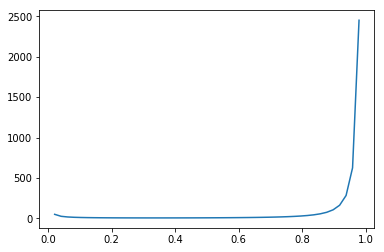

In [56]:
plt.plot(theta,f(theta,1,2))
#plt.plot(theta,f1(theta,1,1,.5,.5))
plt.show()

## 中间

In [ ]:
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.image as mpimg
from tensorflow.contrib.distributions import Bernoulli
import os
import cv2

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train*1./255
x_test = x_test*1./255
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
targets = y_test.reshape(-1)
y_test = np.eye(nb_classes)[targets]

TIM = np.load("./TIM.npy")  

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img

def stand0(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im)
    std = np.std(im)
    std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
    im = (im-mean)/std1
    return im
  
def stand(images):
  for i in range(len(images)):
    images[i] = stand0(images[i])
  return images 

  
def stand10(safe_images):
    safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
    return safe_images
  
def stand1(images):
  for i in range(len(images)):
    images[i] = stand10(images[i])
  return images 

def random_flip(im):
    s = np.random.randint(0,2,1)[0]
    if s == 1:
        im = im[:,:,::-1,...]
    return im

def preprocess(x_batch):
    x_batch = stand(x_batch)
    #x_batch = stand1(x_batch)
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = random_flip(x_batch)
    return x_batch
'''
epsilon = 1e-3
def batch_norm(inputs, scale, beta, training, decay = 0.99):
    
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
    train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
    train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))
    if training:
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
          
def batch_norm(inputs, scale, beta, training, decay = 0.99):
    batch_mean, batch_var = tf.nn.moments(inputs, [0,1,2])
    ema = tf.train.ExponentialMovingAverage(decay=0.99)
    
    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
          
    def otherwise():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(ema.average(batch_mean)), tf.identity(ema.average(batch_var))
    
    mean, var = tf.cond(training,mean_var_with_update,otherwise)
    normed = tf.nn.batch_normalization(inputs, mean, var, beta, scale, 1e-3)
    return normed
'''
epsilon = 1e-3
def batch_norm(inputs, scale, beta, training, decay = 0.99):
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
    train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
    train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))
    if training:
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        #with tf.control_dependencies([train_mean, train_var]):
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

def network(img,dd):
        # network
    with tf.variable_scope('V1', reuse=tf.AUTO_REUSE):
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        #h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=dd)
        h_conv1 = batch_norm(tf.nn.relu(con1), scale1, beta1, training=dd)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        #h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=dd)
        h_conv2 = batch_norm(tf.nn.relu(con2), scale2, beta2, training=dd)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        #h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=dd)
        h_conv3 = batch_norm(tf.nn.relu(con3), scale3, beta3, training=dd)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        #h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=dd)
        h_conv4 = batch_norm(tf.nn.relu(con4), scale4, beta4, training=dd)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=dd)
        h_conv5 = batch_norm(tf.nn.relu(con5), scale5, beta5, training=dd)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=dd)
        h_conv6 = batch_norm(tf.nn.relu(con6), scale6, beta6, training=dd)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        #h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=dd)
        h_conv7 = batch_norm(tf.nn.relu(con7), scale7, beta7, training=dd)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        #h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=dd)
        h_conv8 = batch_norm(tf.nn.relu(con8), scale8, beta8, training=dd)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        #h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=dd)
        h_conv9 = batch_norm(tf.nn.relu(con9), scale9, beta9, training=dd)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        #h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=dd)
        h_conv10 = batch_norm(tf.nn.relu(con10), scale10, beta10, training=dd)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        #h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=dd)
        h_conv11 = batch_norm(tf.nn.relu(con11), scale11, beta11, training=dd)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        #h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=dd)
        h_conv12 = batch_norm(tf.nn.relu(con12), scale12, beta12, training=dd)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        #h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=dd)
        h_conv13 = batch_norm(tf.nn.relu(con13), scale13, beta13, training=dd)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10
    
def network1(img,dd):
    with tf.variable_scope('V2', reuse=tf.AUTO_REUSE):
        # network
        con1 = tf.nn.conv2d(img, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        #h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=dd)
        h_conv1 = batch_norm(tf.nn.relu(con1), sc1, bt1, training=dd)

        con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        #h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=dd)
        h_conv2 = batch_norm(tf.nn.relu(con2), sc2, bt2, training=dd)
        h_pool2 = max_pool_2x2(h_conv2)

        con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
        #h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=dd)
        h_conv3 = batch_norm(tf.nn.relu(con3), sc3, bt3, training=dd)

        con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
        #h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=dd)
        h_conv4 = batch_norm(tf.nn.relu(con4), sc4, bt4, training=dd)
        h_pool4 = max_pool_2x2(h_conv4)

        con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
        #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=dd)
        h_conv5 = batch_norm(tf.nn.relu(con5), sc5, bt5, training=dd)

        con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
        #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=dd)
        h_conv6 = batch_norm(tf.nn.relu(con6), sc6, bt6, training=dd)

        con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
        #h_conv7 = tf.layers.batch_normalization(tf.nn.relu(con7), training=dd)
        h_conv7 = batch_norm(tf.nn.relu(con7), sc7, bt7, training=dd)
        h_pool7 = max_pool_2x2(h_conv7)

        con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
        #h_conv8 = tf.layers.batch_normalization(tf.nn.relu(con8), training=dd)
        h_conv8 = batch_norm(tf.nn.relu(con8), sc8, bt8, training=dd)

        con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
        #h_conv9 = tf.layers.batch_normalization(tf.nn.relu(con9), training=dd)
        h_conv9 = batch_norm(tf.nn.relu(con9), sc9, bt9, training=dd)

        con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
        #h_conv10 = tf.layers.batch_normalization(tf.nn.relu(con10), training=dd)
        h_conv10 = batch_norm(tf.nn.relu(con10), sc10, bt10, training=dd)
        h_pool10 = max_pool_2x2(h_conv10)

        con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
        #h_conv11 = tf.layers.batch_normalization(tf.nn.relu(con11), training=dd)
        h_conv11 = batch_norm(tf.nn.relu(con11), sc11, bt11, training=dd)

        con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
        #h_conv12 = tf.layers.batch_normalization(tf.nn.relu(con12), training=dd)
        h_conv12 = batch_norm(tf.nn.relu(con12), sc12, bt12, training=dd)

        con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
        #h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
        #h_conv13 = tf.layers.batch_normalization(tf.nn.relu(con13), training=dd)
        h_conv13 = batch_norm(tf.nn.relu(con13), sc13, bt13, training=dd)
        h_pool13 = max_pool_2x2(h_conv13)

        h_pool_flat = tf.layers.flatten(h_pool13)
        h_pool_flat1 = tf.stack([h_pool_flat]*n_intergal_sample)

        h = tf.nn.relu(tf.matmul(h_pool_flat1, w0) + b0)
        #h = tf.nn.dropout(h,rate = 1 - 0.7)
        h = tf.nn.relu(tf.matmul(h, w1) + b1)
        logits = tf.matmul(h, w2) + b2

        return logits#num_sample*batch*10


M = 128
n_intergal_sample = 600
D=7*7*64
h1=512
D2=10
max_auc = 0

#for d in ['/device:GPU:0','/device:GPU:1','/device:GPU:2', '/device:GPU:3']:
for d in ['/device:GPU:0']:
    with tf.device(d):
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        tf.reset_default_graph()
        # variables
        noise = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        Y = tf.placeholder(tf.float32, [None,10])
        b = tf.placeholder(tf.float32,shape=(),name='b')
        learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')
        
        scale1 = tf.Variable(tf.ones([64]), trainable=False)
        beta1 = tf.Variable(tf.zeros([64]), trainable=False)
        scale2 = tf.Variable(tf.ones([64]), trainable=False)
        beta2 = tf.Variable(tf.zeros([64]), trainable=False)
        scale3 = tf.Variable(tf.ones([128]), trainable=False)
        beta3 = tf.Variable(tf.zeros([128]), trainable=False)
        scale4 = tf.Variable(tf.ones([128]), trainable=False)
        beta4 = tf.Variable(tf.zeros([128]), trainable=False)
        scale5 = tf.Variable(tf.ones([256]), trainable=False)
        beta5 = tf.Variable(tf.zeros([256]), trainable=False)
        scale6 = tf.Variable(tf.ones([256]), trainable=False)
        beta6 = tf.Variable(tf.zeros([256]), trainable=False)
        scale7 = tf.Variable(tf.ones([256]), trainable=False)
        beta7 = tf.Variable(tf.zeros([256]), trainable=False)
        scale8 = tf.Variable(tf.ones([512]), trainable=False)
        beta8 = tf.Variable(tf.zeros([512]), trainable=False)
        scale9 = tf.Variable(tf.ones([512]), trainable=False)
        beta9 = tf.Variable(tf.zeros([512]), trainable=False)
        scale10 = tf.Variable(tf.ones([512]), trainable=False)
        beta10 = tf.Variable(tf.zeros([512]), trainable=False)
        scale11 = tf.Variable(tf.ones([512]), trainable=False)
        beta11 = tf.Variable(tf.zeros([512]), trainable=False)
        scale12 = tf.Variable(tf.ones([512]), trainable=False)
        beta12 = tf.Variable(tf.zeros([512]), trainable=False)
        scale13 = tf.Variable(tf.ones([512]), trainable=False)
        beta13 = tf.Variable(tf.zeros([512]), trainable=False)
        
        bt1 = tf.stop_gradient(tf.identity(beta1))
        sc1 = tf.stop_gradient(tf.identity(scale1))
        bt2 = tf.stop_gradient(tf.identity(beta2))
        sc2 = tf.stop_gradient(tf.identity(scale2))
        bt3 = tf.stop_gradient(tf.identity(beta3))
        sc3 = tf.stop_gradient(tf.identity(scale3))
        bt4 = tf.stop_gradient(tf.identity(beta4))
        sc4 = tf.stop_gradient(tf.identity(scale4))
        bt5 = tf.stop_gradient(tf.identity(beta5))
        sc5 = tf.stop_gradient(tf.identity(scale5))
        bt6 = tf.stop_gradient(tf.identity(beta6))
        sc6 = tf.stop_gradient(tf.identity(scale6))        
        bt7 = tf.stop_gradient(tf.identity(beta7))
        sc7 = tf.stop_gradient(tf.identity(scale7))        
        bt8 = tf.stop_gradient(tf.identity(beta8))
        sc8 = tf.stop_gradient(tf.identity(scale8))        
        bt9 = tf.stop_gradient(tf.identity(beta9))
        sc9 = tf.stop_gradient(tf.identity(scale9))
        bt10 = tf.stop_gradient(tf.identity(beta10))
        sc10 = tf.stop_gradient(tf.identity(scale10))        
        bt11 = tf.stop_gradient(tf.identity(beta11))
        sc11 = tf.stop_gradient(tf.identity(scale11))
        bt12 = tf.stop_gradient(tf.identity(beta12))
        sc12 = tf.stop_gradient(tf.identity(scale12))        
        bt13 = tf.stop_gradient(tf.identity(beta13))
        sc13 = tf.stop_gradient(tf.identity(scale13))

        w_conv1 = tf.get_variable('w_conv1', [3,3,3,64], initializer = tf.contrib.layers.xavier_initializer())
        w_conv2 = tf.get_variable('w_conv2', [3,3,64,64], initializer = tf.contrib.layers.xavier_initializer())

        w_conv3 = tf.get_variable('w_conv3', [3,3,64,128], initializer = tf.contrib.layers.xavier_initializer())
        w_conv4 = tf.get_variable('w_conv4', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())

        w_conv5 = tf.get_variable('w_conv5', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv6 = tf.get_variable('w_conv6', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
        w_conv7 = tf.get_variable('w_conv7', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())

        w_conv8 = tf.get_variable('w_conv8', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv9 = tf.get_variable('w_conv9', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv10 = tf.get_variable('w_conv10', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w_conv11 = tf.get_variable('w_conv11', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv12 = tf.get_variable('w_conv12', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
        w_conv13 = tf.get_variable('w_conv13', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

        w0_m = tf.get_variable('w_fc1', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_m = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_m = tf.get_variable('w_fc2', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_m = tf.get_variable('b_fc2', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_m = tf.get_variable('w_fc3', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_m = tf.get_variable('b_fc3', [1,10], initializer = tf.contrib.layers.xavier_initializer())
        
        w0_r = tf.get_variable('w_fc1_r', [1*1*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b0_r = tf.get_variable('b_fc1_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w1_r = tf.get_variable('w_fc2_r', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
        b1_r = tf.get_variable('b_fc2_r', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
        w2_r = tf.get_variable('w_fc3_r', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
        b2_r = tf.get_variable('b_fc3_r', [1,10], initializer = tf.contrib.layers.xavier_initializer())

        w0_sigma = w0_r**2
        b0_sigma = b0_r**2
        w1_sigma = w1_r**2
        b1_sigma = b1_r**2
        w2_sigma = w2_r**2
        b2_sigma = b2_r**2

        eps1 = tf.random_normal(shape=[n_intergal_sample,1*1*512, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps2 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps3 = tf.random_normal(shape=[n_intergal_sample,1024, 1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps4 = tf.random_normal(shape=[n_intergal_sample,1,1024], mean=0.0, stddev=1,dtype=tf.float32)
        eps5 = tf.random_normal(shape=[n_intergal_sample,1024, 10], mean=0.0, stddev=1,dtype=tf.float32)
        eps6 = tf.random_normal(shape=[n_intergal_sample,1,10], mean=0.0, stddev=1,dtype=tf.float32)

        w0 = w0_m + eps1 * w0_sigma
        b0 = b0_m + eps2 * b0_sigma
        w1 = w1_m + eps3 * w1_sigma
        b1 = b1_m + eps4 * b1_sigma
        w2 = w2_m + eps5 * w2_sigma
        b2 = b2_m + eps6 * b2_sigma

        # network


        #evaluation
        ###训练接口
        logits0 = network(X,True)
        logits = tf.reduce_mean(logits0,0)
        output0 = tf.nn.softmax(logits0)
        cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y)
        
        probs = tf.reduce_sum(output0*Y,2)
        prob=tf.reduce_mean(probs,0)#积分
        log_prob = tf.log(prob+1e-30)#取log
        #p = tf.reduce_mean(log_prob)#求和
        p = tf.reduce_mean(-cross_ent)

        output, var0 = tf.nn.moments(output0,0)#batch*10
        prob1 = tf.reduce_sum(output*Y,1)
        max_p = tf.reduce_max(output,1)
        ent = tf.reduce_sum(-tf.log(output+1e-30)*output,1)
        Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-30)*output0,2),0)
        MI = ent - Eent
        MI_mean = tf.reduce_sum(MI)

        correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
        ###测试接口
        logits2 = network(X,False)
        logits22 = tf.reduce_mean(logits2,0)
        cross_ent_test = tf.nn.softmax_cross_entropy_with_logits(logits = logits22, labels=Y)
        p_test = tf.reduce_mean(-cross_ent_test)
        
        output2 = tf.nn.softmax(logits2)
        output_test, var_test = tf.nn.moments(output2,0)#batch*10
        max_p_test = tf.reduce_max(output_test,1)
        ent_test = tf.reduce_sum(-tf.log(output_test+1e-30)*output_test,1)
        Eent_test = tf.reduce_mean(tf.reduce_sum(-tf.log(output2+1e-30)*output2,2),0)
        MI_test = ent_test - Eent_test
        MI_mean_test = tf.reduce_sum(MI_test)

        correct_pred_test = tf.equal(tf.argmax(output_test,1), tf.argmax(Y,1))
        accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))

        ##noise接口
        logits1 = network1(noise,True)
        output1 = tf.nn.softmax(logits1)
        output_noise, varent_noise = tf.nn.moments(output1,0)
        max_p_noise = tf.reduce_max(output_noise,1)
        ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-30)*output_noise,1)
        Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-30)*output1,2),0)
        MI_noise = ent_noise - Eent_noise
        MI_noise_mean = tf.reduce_sum(MI_noise)
        
        correct_pred_noise = tf.equal(tf.argmax(output_noise,1), tf.argmax(Y,1))
        accuracy_noise = tf.reduce_mean(tf.cast(correct_pred_noise, tf.float32))

        regularization = 1e-6*(tf.reduce_sum(tf.square(w0_m))+tf.reduce_sum(tf.square(b0_m))
                               +tf.reduce_sum(tf.square(w1_m))+tf.reduce_sum(tf.square(b1_m))
                               +tf.reduce_sum(tf.square(w2_m))+tf.reduce_sum(tf.square(b2_m))
                               +tf.reduce_sum(tf.square(w_conv1))+tf.reduce_sum(tf.square(w_conv2))
                               +tf.reduce_sum(tf.square(w_conv3))+tf.reduce_sum(tf.square(w_conv4))
                               +tf.reduce_sum(tf.square(w_conv5))+tf.reduce_sum(tf.square(w_conv6))+tf.reduce_sum(tf.square(w_conv7))
                               +tf.reduce_sum(tf.square(w_conv8))+tf.reduce_sum(tf.square(w_conv9))+tf.reduce_sum(tf.square(w_conv10))
                               +tf.reduce_sum(tf.square(w_conv11))+tf.reduce_sum(tf.square(w_conv12))+tf.reduce_sum(tf.square(w_conv13)))

        loss = -p*1 + regularization*1 - MI_noise_mean*0.02*0
        loss_test = -p_test + regularization - MI_noise_mean*0.02
# trainin

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver(max_to_keep=5)

config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./density_estimation_cifar10/classification_mnist4/model.ckpt" )
    for i in range(180000):
        
        start_time1 = time.time()
        seed = np.random.randint(0,50000,M)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        #my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
        my_noise = np.reshape(np.random.normal(0,1,[32*32*3*M]),[M,32,32,3])
        #my_noise = TIM[np.random.randint(0,10000,M)]
        #my_noise = stand(my_noise)
        
        #pp = sess.run(output_test,{X: x_batch, Y: y_batch,noise:my_noise, b:False})
            
        if i%1000==0 and i!=0:
            loss_now = sess.run(loss_test,{X: x_batch, Y: y_batch,noise:my_noise, b:1.})
            loss_now1 = sess.run(MI_noise_mean*0.2,{X: x_batch, Y: y_batch,noise:my_noise, b:1.})
            print("loss",loss_now,"-p+regular ",loss_now+loss_now1,"MI",loss_now1)
            
            train_accuracy=[]
            seed1 = np.random.randint(0,50000,10000)
            x_vali = x_train[seed1]
            y_vali = y_train[seed1]
            for j in range(0,100):
                imgs_in = x_vali[j*100:(j+1)*100]
                labels_in = y_vali[j*100:(j+1)*100]
                imgs_in=stand(imgs_in)
                acc0 = sess.run(accuracy_test,{X:imgs_in,Y:labels_in,noise:imgs_in,b:1.})
                train_accuracy.append(acc0)
            train_accuracy = np.array(train_accuracy)
            train_accuracy = np.mean(train_accuracy)
            
            test_accuracy=[]
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in=stand(imgs_in)
                #imgs_in=stand1(imgs_in)
                acc = sess.run(accuracy_test,{X:imgs_in,Y:labels_in,noise:imgs_in,b:1.})
                maxp_in1 = sess.run(max_p_test,{X:imgs_in,noise:imgs_in,b:1.})
                ent_in1 = sess.run(ent_test,{X:imgs_in,noise:imgs_in,b:1.})
                MI_in1 = sess.run(MI_test,{X:imgs_in,noise:imgs_in,b:1.})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy,"train accuracy",train_accuracy)

            for t in range(0,2):
                '''
                if t == 0:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                '''
                if t == 0:
                    safe_images = np.copy(TIM)
                    print("TIM:")
                if t == 1:
                    safe_images = np.reshape(np.random.normal(0,1,[32*32*3*10000]),[10000,32,32,3])
                    #safe_images = (safe_images - np.min(safe_images))/(np.max(safe_images) - np.min(safe_images))
                    print("noise:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,100):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    imgs_OOD = stand(imgs_OOD)
                    #imgs_OOD = stand1(imgs_OOD)
                    maxp_OOD1 = sess.run(max_p_test,{X:imgs_OOD,noise:imgs_OOD,b:1.})
                    ent_OOD1 = sess.run(ent_test,{X:imgs_OOD,noise:imgs_OOD,b:1.})
                    MI_OOD1 = sess.run(MI_test,{X:imgs_OOD,noise:imgs_OOD,b:1.})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
                if t == 0:
                    tmp_indicator = round(100*roc_auc_score(labels, examples), 2)

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[10000,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
            
                
        if i < 10000:
            a = 0.001
        elif i < 20000:
            a = 0.0003
        elif i < 30000:
            a = 0.0001
        elif i < 40000:
            a = 0.00003
        elif i < 50000:
            a = 0.00001
        elif i < 60000:
            a = 0.000003
        elif i < 70000:
            a = 0.000001
        elif i < 80000:
            a = 0.0000003
        else:
            a = 0.0000001

        sess.run(train_step,{X: x_batch, Y: y_batch,noise:my_noise, b:2., learning_rate:a*.2})
        if i%1000==0:
            save_path = saver.save(sess, "./density_estimation_cifar10/classification_mnist%s/model.ckpt" % model_id)
            print("model", model_id,"saved0.02")
            model_id+=1 
